<a href="https://colab.research.google.com/github/kyotoman-koshida/bokete/blob/main/notebooks/20220924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ファイル出力したものを頼りにGOSSを動かしてみる！

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

必要なデータ類のインポートや結合など

In [ ]:
INPUT = "/content/drive/MyDrive/会社/Nishika/bokete" 
train_image_path = "/content/train/"
test_image_path = "/content/test/"
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))

BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')
## テキストの欠損値を補間します
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

image_feature = pd.read_csv(os.path.join(INPUT, "image_feature.csv"), index_col=0)
test_image_feature = pd.read_csv(os.path.join(INPUT, "test_image_feature.csv"), index_col=0)
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")
test_df = pd.merge(test_df, test_image_feature, on="odai_photo_file_name", how="left")

features_text_train_df = pd.read_csv(os.path.join(INPUT, "features_text_train.csv"), index_col=0)
features_text_test_df = pd.read_csv(os.path.join(INPUT, "features_text_test.csv"), index_col=0)
train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)


Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

print(train_x.shape)
print(valid_x.shape)

(19969, 1025)
(4993, 1025)


### 今回のモデルは、LightGBMのGOSSを用いる

In [ ]:
lgbm_params = {  
    "boosting_type":"goss",
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.618252	valid's binary_logloss: 0.663839
[100]	train's binary_logloss: 0.583298	valid's binary_logloss: 0.66139
[150]	train's binary_logloss: 0.554334	valid's binary_logloss: 0.662362
Early stopping, best iteration is:
[104]	train's binary_logloss: 0.581452	valid's binary_logloss: 0.66095


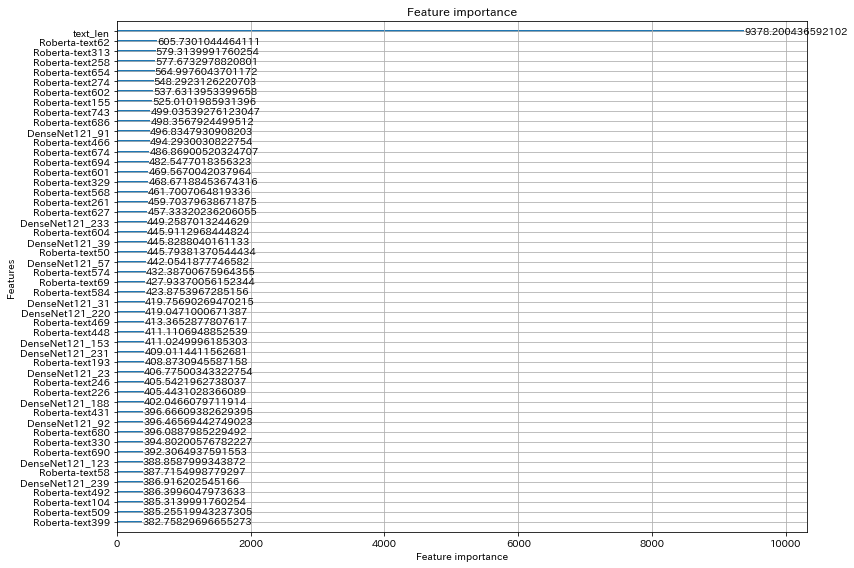

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.607450430602844


Text(0.5, 52.0, 'Predict')

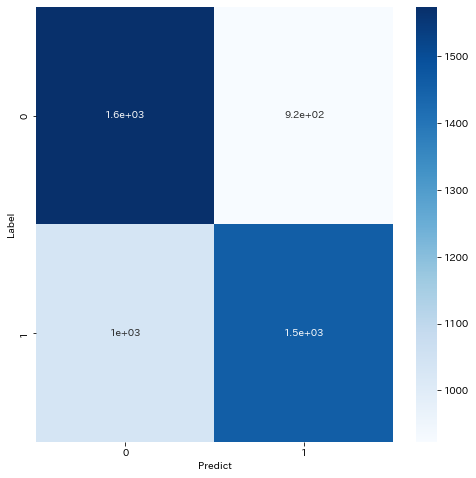

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

### 予測してみる

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.405391
1,tsgqmfpef,0.495961
2,owjcthkz2,0.396114
3,rvgaocjyy,0.368898
4,uxtwu5i69,0.732787


In [ ]:
OUTPUT = "/content/drive/MyDrive/会社/Nishika/bokete/results" # ディレクトリを指定してください
submission_df.to_csv(os.path.join(OUTPUT,'20220924goss-submission.csv'), index=False)

他の試作

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）
